In [23]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile as shp
import geopy.distance as dist
from tqdm import tqdm, trange

df = pd.read_csv('../data/scooterdata20210719.csv')
shp_path = '../data/Census_Block_Groups_2010/Census_Block_Groups_2010.shp'
sf = shp.Reader(shp_path)

In [24]:
# from math import radians, cos, sin, asin, sqrt
# def haversine(lat1, lon1, lat2, lon2):
#     """
#     Calculate the great circle distance between two points 
#     on the earth (specified in decimal degrees)
#     """
#     # convert decimal degrees to radians 
#     lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
#     # haversine formula 
#     dlon = lon2 - lon1 
#     dlat = lat2 - lat1 
#     a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
#     c = 2 * asin(sqrt(a)) 
#     # Radius of earth in kilometers is 6371
#     km = 6371* c
#     return km

def read_shapefile(sf):
    #fetching the headings from the shape file
    fields = [x[0] for x in sf.fields][1:]
#fetching the records from the shape file
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
#converting shapefile data into pandas dataframe
    df = pd.DataFrame(columns=fields, data=records)
#assigning the coordinates
    df = df.assign(coords=shps)
    return df

def plot_shape(id, s=None):
    plt.figure()
    #plotting the graphical axes where map ploting will be done
    ax = plt.axes()
    ax.set_aspect('equal')
#storing the id number to be worked upon
    shape_ex = sf.shape(id)
#NP.ZERO initializes an array of rows and column with 0 in place of each elements 
    #an array will be generated where number of rows will be(len(shape_ex,point))and number of columns will be 1 and stored into the variable
    x_lon = np.zeros((len(shape_ex.points),1))
#an array will be generated where number of rows will be(len(shape_ex,point))and number of columns will be 1 and stored into the variable
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
#plotting using the derived coordinated stored in array created by numpy
    plt.plot(x_lon,y_lat) 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
# use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
    return x0, y0

def plot_map(sf, x_lim = None, y_lim = None):
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
#             plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)

In [3]:
# comp = 'link'
# df_dtown = df[(df['lat']>=47.5909)&(df['lat']<=47.6188)&(df['lon']>=-122.3609)&(df['lon']<=-122.3141)]
# link_ids=df_dtown[df_dtown['company']==comp]['bike_id'].unique()
# BBox = (-122.3609,-122.3141,47.5909,47.6188)

# trip_count = 0

# dtown = plt.imread('../data/downtown.png')
# fig, ax = plt.subplots(figsize = (20.72,18.26))
# for idx in range(len(link_ids)):
#     coords = df_dtown[(df_dtown['company']==comp)&(df_dtown['bike_id']==link_ids[idx])][['lat','lon','timestamp']].to_numpy()
#     if haversine(coords[0,0],coords[0,1],coords[-1,0],coords[-1,1])>=0.4:
#         trip_count += 1
#         ax.plot(coords[:,1],coords[:,0],'o-', lw=3)
# ax.set_title('Downtown Scooter Trips')
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])
# ax.imshow(dtown, zorder=0, extent=BBox, aspect='auto')
# plt.savefig('../figures/downtown_trips_link.png', format='png')
# plt.show()
# print(f'{trip_count} trips')

In [4]:
import geopy.distance as dist

comp_ = ('link','wheels')
trip_count = np.zeros(len(comp_))
trip_time = np.zeros(len(comp_))
trips = pd.DataFrame()

for comp in comp_:
    df_comp = df[(df['company']==comp)&(df['is_disabled']==0)]
    ids=df_comp['bike_id'].unique()
    print(f'{len(ids)} unique {comp} ids')
    n = 0
    for scooter_id in tqdm(ids):
        coords = df_comp[(df_comp['bike_id']==scooter_id)][['lat','lon','timestamp']].to_numpy()
        state = 'stopped'
        for i in range(coords.shape[0]-1):
            if dist.geodesic((coords[i,0],coords[i,1]),(coords[i+1,0],coords[i+1,1])).km>=0.1:
                if state != 'moving':
                    time_start = coords[i,2]
                    lat_start = coords[i,0]
                    lon_start = coords[i,1]
                state = 'moving'
            else:
                if state == 'moving':
                    state = 'end trip'
                    trips = trips.append({'bike_id':scooter_id, 'company':comp,
                                         'time_start':time_start, 'time_end':coords[i,2],
                                         'lat_start':lat_start, 'lon_start':lon_start,
                                         'lat_end':coords[i,0], 'lon_end':coords[i,1]},
                                         ignore_index=True)                    
                else:
                    state = 'stopped'
        n += 1
        if n%1000 == 0:
            print(f'{n} {comp} ids processed, {len(trips)} trips detected')

1709 unique link ids
1000 link ids processed, 123 trips detected
571 unique wheels ids


KeyboardInterrupt: 

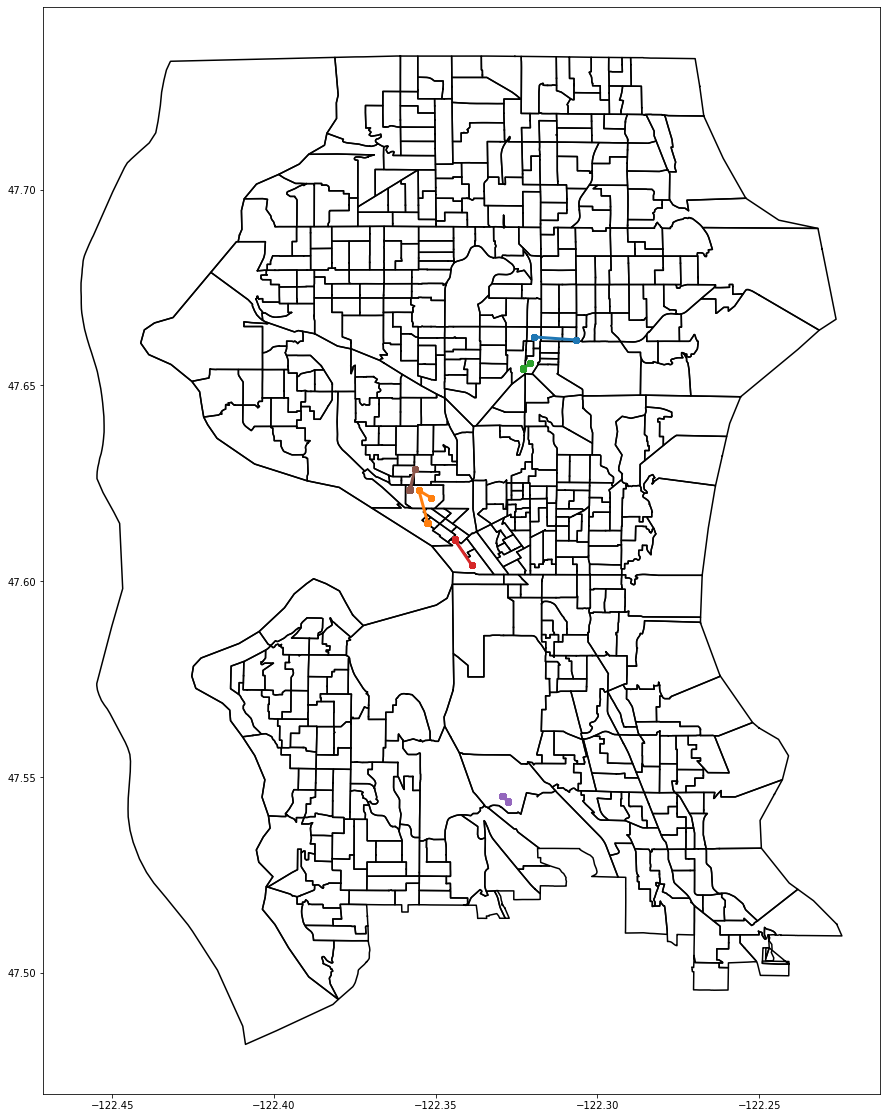

In [25]:
comp_ = ('link','wheels')
for comp in comp_:
    comp_ids=df[df['company']==comp]['bike_id'].unique()
    fig, ax = plt.subplots(figsize = (15,20))
    plot_map(sf)
    for idx in trange(len(comp_ids)):
        coords = df[(df['company']==comp)&(df['bike_id']==comp_ids[idx])][['lat','lon','timestamp']].to_numpy()
        if dist.geodesic((coords[0,0],coords[0,1]),(coords[-1,0],coords[-1,1]))>=0.1:
            ax.plot(coords[:,1],coords[:,0],'o-', lw=3)
    ax.set_title(comp+' Scooter Trips')
    plt.savefig('../figures/trips_'+comp+'.png', format='png')
    plt.show()
    print(f'{trip_count} trips')

In [6]:
trips

,bike_id,company,lat_end,lat_start,lon_end,lon_start,time_end,time_start
0,0b665d9b-89c2-47c4-adb9-3c85284865ff,link,47.662400,47.661620,-122.319690,-122.306600,1.626726e+09,1.626725e+09
1,29c5ecfa-f010-40d8-829c-7fe45a49efdb,link,47.623190,47.614810,-122.355210,-122.352460,1.626724e+09,1.626722e+09
2,29c5ecfa-f010-40d8-829c-7fe45a49efdb,link,47.621330,47.623190,-122.351480,-122.355210,1.626725e+09,1.626725e+09
3,acd17b0a-6706-4aec-9fa9-cc1d0ec5d3d0,link,47.655640,47.654380,-122.320800,-122.322990,1.626727e+09,1.626727e+09
4,61b64f79-5fb9-4b9f-a0c6-474f184bef66,link,47.610670,47.604090,-122.344190,-122.338850,1.626720e+09,1.626718e+09
...,...,...,...,...,...,...,...,...
529,9ff7107a-b112-4873-8651-987a6aa0836c,wheels,47.603874,47.602295,-122.328964,-122.331757,1.626724e+09,1.626722e+09
530,dce57b11-422d-495b-8872-f8dc08e3c067,wheels,47.628143,47.607246,-122.301552,-122.316696,1.626720e+09,1.626719e+09
531,7e2e8b0b-9b29-4634-a876-ec831e5519d3,wheels,47.656750,47.619225,-122.315567,-122.281532,1.626718e+09,1.626715e+09
532,7e2e8b0b-9b29-4634-a876-ec831e5519d3,wheels,47.668519,47.656750,-122.297166,-122.315567,1.626723e+09,1.626722e+09


In [20]:
def extract_trips(data, comp_=('lime','link','wheels')):
    trip_count = np.zeros(len(comp_))
    trip_time = np.zeros(len(comp_))
    trips = pd.DataFrame()

    for comp in comp_:
        df_comp = data[(data['company']==comp)&(data['is_disabled']==0)]
        df_comp = df_comp.sort_values(by='timestamp')
        ids=df_comp['bike_id'].unique()
        print(f'{len(ids)} unique {comp} ids')
        n = 0
        for scooter_id in tqdm(ids):
            coords = df_comp[(df_comp['bike_id']==scooter_id)][['lat','lon','timestamp']].to_numpy()
            state = 'stopped'
            for i in range(coords.shape[0]-1):
                if dist.geodesic((coords[i,0],coords[i,1]),(coords[i+1,0],coords[i+1,1])).km>=0.1:
                    if state != 'moving':
                        time_start = coords[i,2]
                        lat_start = coords[i,0]
                        lon_start = coords[i,1]
                    state = 'moving'
                else:
                    if state == 'moving':
                        state = 'end trip'
                        trips = trips.append({'bike_id':scooter_id, 'company':comp,
                                              'time_start':time_start, 'time_end':coords[i,2],
                                              'lat_start':lat_start, 'lon_start':lon_start,
                                              'lat_end':coords[i,0], 'lon_end':coords[i,1]},
                                              ignore_index=True)                    
                    else:
                        state = 'stopped'
            n += 1
    return trips

In [22]:
data = pd.read_csv('../data/20210720-23-scooterdata.csv')
trips = extract_trips(data, comp_=['wheels'])

  0%|                                                                                  | 1/837 [00:00<02:47,  4.99it/s]

837 unique wheels ids


100%|████████████████████████████████████████████████████████████████████████████████| 837/837 [03:06<00:00,  4.49it/s]


In [10]:
trips['distance'] = trips.apply(lambda row: dist.geodesic((row['lat_start'],row['lon_start']),(row['lat_end'],row['lon_end'])).km, axis=1)

In [13]:
trips.distance.to_numpy().max()

19.19791575403414